In [196]:
# Library imports
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt

import numpy as np
from scipy.stats import expon
from scipy.stats import uniform
import time
from scipy.optimize import minimize

In [2]:
# Utility Function

def utility(ki,gammai,kj,Vj,t):
    """
    Computes the J x I matrix of uij's, patient's i utility from patient j if a visit takes place

    Arguments:
        ki: 1 x I vector of patients' "medical necesity", κ_i parameter.
        gammai: 1 x I vector of patients' "taste for certificates", γ_i parameter.
        kj: J x 1 vector of doctors' chosen threshold, κ_j parameter.
        Vj: J x 1 vector of doctors' "service quality", V_j parameter.
        t: parametrized cost of visit.
    """

    # Reshaping parameters to ensure proper broadcasting
    ki = np.array(ki).reshape((1,-1))             # 1 x I
    gammai = np.array(gammai).reshape((1,-1))     # 1 x I
    kj = np.array(kj).reshape((-1,1))             # J x 1
    Vj = np.array(Vj).reshape((-1,1))             # J x 1

    return Vj * ki - t + np.where(ki >= kj, gammai, 0)
                    # This way γ_i is summed if patient i's κ_i is above doctor j's threshold κ_j.

In [3]:
# Logit Search definition

class LogitSearch:

    def __init__(self, ki,  # 1 x I vector of patients' "medical necesity", κ_i parameter.
                    gammai, # 1 x I vector of patients' "taste for certificates", γ_i parameter.
                    kj,     # J x 1 vector of doctors' chosen threshold, κ_j parameter.
                    Vj,     # J x 1 vector of doctors' "service quality", V_j parameter.
                    t,      # Scalar. Parametrized cost of visit.
                    λ):     # Scalar. Logit shape parameter.
    
        # Save parameters
        self.ki, self.gammai, self.kj, self.Vj, self.t, self.λ = ki, gammai, kj, Vj, t, λ

    def U(self):
        """
        Computes the J x I matrix of uij's, patient's i utility from patient j if a visit takes place.
        See definition above.
        """

        # Unpack parameters
        ki, gammai, kj, Vj, t = self.ki, self.gammai, self.kj, self.Vj, self.t

        return utility(ki,gammai,kj,Vj,t)
    
    def alpha_matrix(self):
        """
        Intermediate matrix used to compute S matrix of patients' sij's.
        alpha_ij equals e^(λ*uij) if uij > 0, else 0 (free disposal requirement)
        """

        λ = self.λ  # scalar
        U = self.U()  # J x I matrix of uij's

        return np.where(U > 0, np.exp(λ*U), 0)
    
    def S(self):
        """
        J x I matrix 'S' of patients' strategy vectors S_i, where each component sij stands for
        the probability that patient i visits doctor j.

        (Implicit) arguments:
            ki: 1 x I vector of patients' "medical necesity", κ_i parameter.
            gammai: 1 x I vector of patients' "taste for certificates", γ_i parameter.
            kj: J x 1 vector of doctors' chosen threshold, κ_j parameter.
            Vj: J x 1 vector of doctors' "service quality", V_j parameter.
            t: Scalar. Parametrized cost of visit.
            λ: Scalar. Logit shape parameter.

        Returns:
            s_ij  =  alpha_ij / Σ_j=1^J (alpha_ij)       if      Σ_j=1^J (alpha_ij) > 0
                  =  0                                   ~
                where
            alpha_ij  =  e^(λ*uij)        if      uij > 0
                      =  0                 ~

        Output form:
            s_{i=1,j=1}   s_{i=2,j=1}   ...   s_{i=I,j=1}
            s_{i=1,j=2}   ...                   ...
            # ...                               ...
            s_{i=1,j=J}   ...           ...   s_{i=I,j=J}

        Note:
            It's set up to handle the posibility that no doctors give a certain patient i positive
            utility, in which case he visits none of them -- i.e. S_i = vector(0).
            In all other cases the probability that i visits "some" doctor equals 1.
        """

        # alpha_matrix is a J x I matrix where alpha_ij equals e^(λ*uij) if uij > 0, else 0
        alpha_matrix = self.alpha_matrix()
        # alphai_total outputs the column-wise sum of alpha_ij's, i.e. the total by patient
        alphai_total = np.sum(alpha_matrix, axis = 0)

        with np.errstate(divide='ignore', invalid='ignore'):
            # To avoid pesky division by zero warning      
            return np.where(alphai_total != 0, alpha_matrix/alphai_total, 0)

In [4]:
# Schnell Search definition

class SchnellSearch:

    def __init__(self, ki,  # 1 x I vector of patients' "medical necesity", κ_i parameter.
                    gammai, # 1 x I vector of patients' "taste for certificates", γ_i parameter.
                    kj,     # J x 1 vector of doctors' chosen threshold, κ_j parameter.
                    Vj,     # J x 1 vector of doctors' "service quality", V_j parameter.
                    t,      # Scalar. Parametrized cost of visit.
                    beta):  # Scalar. Reserve utility discount parameter.
    
        # Save parameters
        self.ki, self.gammai, self.kj, self.Vj, self.t, self.beta = ki, gammai, kj, Vj, t, beta

    def U(self):
        """
        Computes the J x I matrix of uij's, patient's i utility from patient j if a visit takes place.
        See definition above.
        """

        # Unpack parameters
        ki, gammai, kj, Vj, t = self.ki, self.gammai, self.kj, self.Vj, self.t

        return utility(ki,gammai,kj,Vj,t)
    
    def U_root(self):
        """ 
        Returns the J-sized vector of patients' reserve utility (U_bar) using vectorization 
        """

        beta = self.beta
        if (beta >= 1 or beta < 0):   raise ValueError("Invalid beta. Please choose β in [0,1).")

        # We sort U column-wise, it's J x I
        U_matrix = np.sort(self.U(), axis=0)
        J = U_matrix.shape[0]
        I = U_matrix.shape[1]

        # Upper diagonal ones column
        greater_than = np.triu(np.ones((J,J)))
        # Total sum of uij for j above u_bar_i
        sum_of_uijs = greater_than @ U_matrix
        # Number of j doctors whose uij is above u_bar_i
        number_of_js = np.arange(J, 0, -1).reshape(-1,1)
        # Average expected ui when selecting u_bar_i threshold
        U_over_average = sum_of_uijs / number_of_js
        # How much that average is above the threshold
        gain_over_reserve = U_over_average - U_matrix

        # β / 1 - β
        beta_multiplier = beta / (1 - beta)
        # β / 1 - β * int_U U - U_bar dF(U)
        RHS = beta_multiplier * gain_over_reserve
        # | U_bar - β / 1 - β * int_U U - U_bar dF(U) |, which we define as error
        error = np.abs(U_matrix - RHS)
        # Row-wise take the index of the uij which minimizes error
        min_index = np.argmin(error, axis = 0)
        # Select the respecttive index for each row, outputting the argmin
        U_roots = U_matrix[min_index, np.arange(I)]

        # We select the U which minimizes error as opposed to computing the root
        # directly, which in this case doesn't matter, as we're working with
        # a discrete vector of doctors

        # Where the root is below 0, we select 0, to fulfill 'free disposal'

        # We select the U which minimizes error as opposed to computing the root
        # directly, which in this case doesn't matter, as we're working with
        # a discrete vector of doctors

        # Where the root is below 0, we select 0, to fulfill 'free disposal'
        return np.maximum(U_roots, 0)
    
    def S(self): 
        """
        J x I matrix 'S' of patients' strategy vectors S_i, where each component sij stands for
        the probability that patient i visits doctor j.

        (Implicit) arguments:
            ki: 1 x I vector of patients' "medical necesity", κ_i parameter.
            gammai: 1 x I vector of patients' "taste for certificates", γ_i parameter.
            kj: J x 1 vector of doctors' chosen threshold, κ_j parameter.
            Vj: J x 1 vector of doctors' "service quality", V_j parameter.
            t: Scalar. Parametrized cost of visit.
            λ: Scalar. Logit shape parameter.

        Returns:
            s_ij  =  1 / Σ_j=1^J I[uij > u_bar_i]       if      uij > u_bar_i 
                  =  0                                   ~
                where
            alpha_ij  =  e^(λ*uij)        if      uij > 0
                      =  0                 ~

        Output form:
            s_{i=1,j=1}   s_{i=2,j=1}   ...   s_{i=I,j=1}
            s_{i=1,j=2}   ...                   ...
            # ...                               ...
            s_{i=1,j=J}   ...           ...   s_{i=I,j=J}

        Note:
            It's set up to handle the posibility that no doctors give a certain patient i positive
            utility, in which case he visits none of them -- i.e. S_i = vector(0).
            In all other cases the probability that i visits "some" doctor equals 1.
        """

        # U matrix and U_bar vector
        U_matrix = self.U()   
        U_bars = self.U_root().reshape(1,-1)
        
        # Array which = 1 if uij > u_bar_i
        U_over_reserve = np.where(U_matrix >= U_bars, 1, 0)
        # sij is 1 divided by the total of doctors j which uij > u_bar_i, for each patient i
        sum_above = np.sum(U_over_reserve, axis = 0)
        with np.errstate(divide='ignore', invalid='ignore'):
            # To avoid pesky division by zero warning       
            return np.where(sum_above > 0,
                            np.divide(U_over_reserve, sum_above),
                            0)    

In [5]:
# Best response functions

def best_response(k0,                   # Input vector
                  custom_function,      # Function to be maximized
                  start, stop):    # Inputs for the linspace
    """
    Outputs 2 decimals best response vector within specified grid to k0 vector.

    Arguments:
        k0: Initial vector to be used for best response computation.
        custom_function: Function maximized whose argmax is the best response.
        Start, stop: Specify grid within which the maximal for custom_function is to be searched.
    """
    
    # We choose an 0.1 step size to start, to span the whole range
    linspace_values = np.arange(start, stop + 0.1, 0.1)

    k_output = []
    # Plot results for each index in i_values
    for i in range(len(k0)):
        # Store the results of the function evaluations for this component
        results_1d = []

        # Keep the original vector unchanged for components not in i_values
        k_fixed = np.copy(k0)
        
        # Evaluate the function over the linspace
        for value in linspace_values:
            k_fixed[i] = value  # Update the i-th component
            result = custom_function(k_fixed)[i]  # Evaluate the function (assumes f returns a vector)
            results_1d.append(result)

        max_index = np.argmax(results_1d)

        new_k = linspace_values[max_index]
        step = 0.09

        if new_k == 0:
            k_fixed[i] = new_k
            result_zero = custom_function(k_fixed)[i]
            k_fixed[i] += 0.01
            result_prime = custom_function(k_fixed)[i]

            if result_prime > result_zero:
                decimals = np.linspace(new_k, new_k + step, 10) # 10 values above inc. 0
                results_2d = []
                # Evaluate the function over the linspace
                for value in decimals:
                    k_fixed[i] = value  # Update the i-th component
                    result = custom_function(k_fixed)[i]  # Evaluate the function (assumes f returns a vector)
                    results_2d.append(result)
                    
                max_index_2 = np.argmax(results_2d)
                result_k = decimals[max_index_2]
                k_output.append(result_k)    

            else:
                k_output.append(new_k)

        elif new_k == 1:
            k_fixed[i] = new_k
            result_one = custom_function(k_fixed)[i]
            k_fixed[i] -= 0.01
            result_prime = custom_function(k_fixed)[i]

            if result_prime > result_one:
                decimals = np.linspace(new_k - step, new_k, 10) # 10 values below inc. 1
                results_2d = []
                # Evaluate the function over the linspace
                for value in decimals:
                    k_fixed[i] = value  # Update the i-th component
                    result = custom_function(k_fixed)[i]  # Evaluate the function (assumes f returns a vector)
                    results_2d.append(result)
                    
                max_index_2 = np.argmax(results_2d)
                result_k = decimals[max_index_2]
                k_output.append(result_k)    

            else:
                k_output.append(new_k)

        else:
            decimals = np.linspace(new_k - step, new_k + step, 19)
            # 19 because 9 decimal steps on either side plus the scalar itself

            results_2d = []
            # Evaluate the function over the linspace
            for value in decimals:
                k_fixed[i] = value  # Update the i-th component
                result = custom_function(k_fixed)[i]  # Evaluate the function (assumes f returns a vector)
                results_2d.append(result)

            max_index_2 = np.argmax(results_2d)
            result_k = decimals[max_index_2]
            k_output.append(result_k)

    return np.array(k_output)

def best_exact(k0, n, custom_function):
    """
    Meant to be used AFTER achieving an n - 1 decimal equilibrium, it makes the equilibrium vector exact by
    one more decimal.

    Arguments:
        k0: Initial k vector, meant to be the output of an n - 1 decimals equilibrium search.
        n: Decimals of precision in k-responses.
        custom_function: Function to be maximized for best response within specified grid.
    """

    h = 1/(10**n)
    step = 9*h
    num_full = 19
    num_truncated = 10

    k_output = []
    for i in range(len(k0)):
        k_fixed = np.copy(k0)
        k_value = k0[i]

        if k_value == 0:
            k_fixed[i] = k_value
            result_zero = custom_function(k_fixed)[i]
            k_fixed[i] += h
            result_prime = custom_function(k_fixed)[i]

            if result_prime > result_zero:
                decimals = np.linspace(k_value, k_value + step, num_truncated)
                results = []
                # Evaluate the function over the linspace
                for value in decimals:
                    k_fixed[i] = value  # Update the i-th component
                    result = custom_function(k_fixed)[i]  # Evaluate the function (assumes f returns a vector)
                    results.append(result)
                    
                max_index = np.argmax(results)
                result_k = decimals[max_index]
                k_output.append(result_k)    

            else:
                k_output.append(k_value)

        elif k_value == 1:
            k_fixed[i] = k_value
            result_one = custom_function(k_fixed)[i]
            k_fixed[i] -= h
            result_prime = custom_function(k_fixed)[i]

            if result_prime > result_one:
                decimals = np.linspace(k_value, k_value + step, num_truncated)
                results = []
                # Evaluate the function over the linspace
                for value in decimals:
                    k_fixed[i] = value  # Update the i-th component
                    result = custom_function(k_fixed)[i]  # Evaluate the function (assumes f returns a vector)
                    results.append(result)
                    
                max_index = np.argmax(results)
                result_k = decimals[max_index]
                k_output.append(result_k)    

            else:
                k_output.append(k_value)

        else:
        
            decimals = np.linspace(k_value - step, k_value + step, num_full)

            results = []
            # Evaluate the function over the linspace
            for value in decimals:
                k_fixed[i] = value  # Update the i-th component
                result = custom_function(k_fixed)[i]  # Evaluate the function (assumes f returns a vector)
                results.append(result)

            max_index = np.argmax(results)
            result_k = decimals[max_index]
            k_output.append(result_k)

    return np.array(k_output)


In [6]:
# Equilibrium function

class SearchEq:
    
    def __init__(self,  I,  # Number of patients in the whole market
                        F,  # Distribution of κi
                        G,  # Distribution of γi
                        t,  # Cost of visit
                        z,  # Search function parameter
                        R,  # Revenue function Rj
                        P,  # Punishment function Pj
                        V,  # Given vector of Vj
                        sij, # Search function
                        N = 10000): 
       
        self.I, self.F, self.G, self.t, self.z = I, F, G, t, z      # Save parameters
        self.R, self.P, self.V, self.sij, self.N = R, P, V, sij, N         

    
    def S(self, k0, s=123):
        """MC simulation of the set of patient strategies out of a given set κ0 of doctor thresholds, seed s"""

        I, F, G, t, z, V, sij = self.I, self.F, self.G, self.t, self.z, self.V, self.sij    # Unpack parameters
        
        rng = np.random.RandomState(s)
        ki = F.rvs(size=I, random_state=rng).reshape((1,-1))    # Sample of patients out of distribution
        gammai = G.rvs(size=I, random_state=rng).reshape((1,-1))
        
        Vj = V
        kj = k0

        return sij(ki,gammai,kj,Vj,t,z).S()

    def Q(self, k0, s=123):
        """Vector of expected patient demand by each doctor j out of an MC simulation of Si"""

        S = self.S(k0, s)

        return np.divide(self.N,self.I) * np.sum(S, axis = 1)
    
    def X(self, k0, s=123):
        """Vector of expected certificates granted by each doctor j out of an MC simulation of Si"""

        S = self.S(k0, s)
        F, I = self.F, self.I
        rng = np.random.RandomState(s)
        ki = F.rvs(size=I, random_state=rng).reshape((1,-1))
        # We recreate the ki vector with the same seed, so it's the same
        
        ki_greater = np.array(ki.reshape((1,-1)) >= k0.reshape((-1,1))).astype(int) 

        return np.divide(self.N,self.I) * np.sum(S*ki_greater, axis = 1)
    
    def utility(self, k0, s=123):

        R, P = self.R, self.P
        Q, X = self.Q(k0, s), self.X(k0, s)

        return R(Q) - P(X)

    def FOC(self, k0, dR, dP, s=123):
        """Out of the previous MC results, it outputs the value of evaluated FOC"""

        Q = self.Q(k0, s)
        X = self.X(k0, s)
        dQ = self.dQ(k0)         # Jacobians of Q and J
        dX = self.dX(k0)
        dQ_gradient = np.diagonal(dQ)   # For the FOC we just use the gradient
        dX_gradient = np.diagonal(dX)

        return dR(Q)*dQ_gradient - dP(X)*dX_gradient
    
    def simple_FOC(self, k0, dR, dP, s=123):
        """Out of the previous MC results, it outputs the value of evaluated FOC"""

        Q = self.Q(k0, s)
        X = self.X(k0, s)

        return (dR(Q) - dP(X))
    

    def Eq_k(self, k0, decimals, max_iter = 20, s=123):
        """Outputs the equilibrium strategies of doctors"""

        if (decimals < 2 or decimals != int(decimals)): 
            raise ValueError("Invalid n. Please choose integer >= 2.")

        x = k0 + 1
        y = k0

        start = self.F.ppf(0)
        stop = self.F.ppf(1)
        custom_function = lambda x: self.utility(x, s)

        lambda_best = lambda x: best_response(x, custom_function, start, stop)

        n = 0
        while not np.array_equal(x, y):
            n += 1
            x = y
            if n > max_iter:
                print(f"Convergence not achieved, max iterations reached: {max_iter}")
                break
            y = lambda_best(x)

        if n <= max_iter:
            print(f"Two decimal convergence achieved in {n} iterations.")
            
        if decimals == 2:
            return np.array(y)
        else:
            i = 2

            while i <= decimals:
                i += 1
                lambda_best_exact = lambda x: best_exact(x, i, custom_function)
                x = y + 1
                t = 0
                while not np.array_equal(x,y):
                    t += 1
                    x = y
                    if(t > max_iter):
                        print("Convergence not acheived, max iterations")
                        break
                    y = lambda_best_exact(x)

        return np.array(y)

                

In [7]:
# PARAMETERS

I = 10000
J = 50

b = 5
F = uniform(scale = 1)
G = uniform(scale = 1)
H = uniform(scale = 10)

f = lambda x: F.pdf(x)
g = lambda x: G.pdf(x)

rng = np.random.RandomState(seed=123)         # Set up number generator using seed
V = H.rvs(size=J, random_state=rng)     # Create J-size vector of Vj values using H
V = np.sort(V)

r = 1.5
p = 1/100

R = lambda x: r * x
P = lambda x: p/2 * x**2

dR = lambda x: r + x - x
dP = lambda x: p * x

df = lambda x: -b*f(x)

k0 = np.ones(J)*0.5

λ = 1
t = 1
beta = 0.7

In [149]:
# Some more parameters

ki = F.rvs(size=I, random_state=rng).reshape((1,-1))    # Sample of patients out of distribution
gammai = G.rvs(size=I, random_state=rng).reshape((1,-1))

Vj = V
kj = k0

U_matrix = utility(ki,gammai,kj,Vj,t)
U_column = U_matrix[:,0]
V_example = np.linspace(0.2,10,50)

In [189]:
Logit_S_lambda = lambda J: SearchEq(I, F, G, t, λ, R, P, H.rvs(size=J), LogitSearch).S(np.linspace(0,1,J))
Schnell_S_lambda = lambda J: SearchEq(I, F, G, t, λ, R, P, H.rvs(size=J), SchnellSearch).S(np.linspace(0,1,J))


Logit_utility_lambda = lambda J: SearchEq(I, F, G, t, λ, R, P, H.rvs(size=J), LogitSearch).utility(np.linspace(0,1,J))
Logit_eq_lambda = lambda J: SearchEq(I, F, G, t, λ, R, P, H.rvs(size=J), LogitSearch).Eq_k(np.linspace(0,1,J),2)


Two decimal convergence achieved in 2 iterations.
Two decimal convergence achieved in 3 iterations.
Two decimal convergence achieved in 3 iterations.
Two decimal convergence achieved in 3 iterations.
Two decimal convergence achieved in 3 iterations.
Two decimal convergence achieved in 3 iterations.
Two decimal convergence achieved in 2 iterations.
Two decimal convergence achieved in 2 iterations.
Two decimal convergence achieved in 3 iterations.
Two decimal convergence achieved in 3 iterations.
Two decimal convergence achieved in 2 iterations.
Two decimal convergence achieved in 2 iterations.
Two decimal convergence achieved in 3 iterations.
Two decimal convergence achieved in 3 iterations.
Two decimal convergence achieved in 3 iterations.
Two decimal convergence achieved in 3 iterations.
Two decimal convergence achieved in 4 iterations.
Two decimal convergence achieved in 3 iterations.
Two decimal convergence achieved in 3 iterations.
Two decimal convergence achieved in 3 iterations.


Two decimal convergence achieved in 2 iterations.
Two decimal convergence achieved in 2 iterations.
Two decimal convergence achieved in 2 iterations.
Two decimal convergence achieved in 2 iterations.
Two decimal convergence achieved in 6 iterations.
Two decimal convergence achieved in 3 iterations.
Two decimal convergence achieved in 3 iterations.
Two decimal convergence achieved in 4 iterations.
Two decimal convergence achieved in 3 iterations.
Two decimal convergence achieved in 3 iterations.
Two decimal convergence achieved in 4 iterations.
Two decimal convergence achieved in 4 iterations.
Two decimal convergence achieved in 3 iterations.
Two decimal convergence achieved in 3 iterations.
Two decimal convergence achieved in 3 iterations.
Two decimal convergence achieved in 4 iterations.
Two decimal convergence achieved in 4 iterations.
Two decimal convergence achieved in 2 iterations.
Two decimal convergence achieved in 3 iterations.
Two decimal convergence achieved in 4 iterations.


In [234]:
# TIMING FUNCTIONS

def timing(J, function, H):

    # Initialize the result array
    result = np.zeros((J, 2))

    # Test the function with vector sizes from 1 to 10
    for i in range(J):  # Create a random vector of size i
        start_time = time.time()  # Start the timer
        function(i+1)     # Call the function
        end_time = time.time()    # End the timer
        
        # Populate the result array
        result[i, 0] = i + 1  # Vector size
        result[i, 1] = end_time - start_time  # Time taken

    return result

def graph_time(n, x, y, **scatter_kwargs):

    def quadratic_fit(x, y):

        def objective(c):
            # c[0] is the quadratic coefficient, c[1] is the linear coefficient
            return np.sum((y - (c[0] * x**2 + c[1] * x))**2)

        # Initial guess for coefficients (c[0], c[1])
        initial_guess = [1, 0]

        # Constraints: c[1] >= 0
        constraints = ({'type': 'ineq', 'fun': lambda c: c[1]})  # Linear coefficient must be non-negative

        result = minimize(objective, initial_guess, constraints=constraints)

        return [result.x[0],result.x[1],0]  # Returns the coefficients (quadratic, linear)

    if n == 1:
        coefs = np.polyfit(x, y, 1)
    elif n == 2:
        coefs = quadratic_fit(x, y)
    else:
        raise ValueError("Choose n = 1 or 2")
    
    fit = np.polyval(coefs, x)

    return plt.plot(x, fit, **scatter_kwargs)

In [ ]:
Logit_eq_lambda = lambda J: SearchEq(I, F, G, t, λ, R, P, H.rvs(size=J), LogitSearch).Eq_k(np.linspace(0,1,J),2)
Logit_eq = timing(30, Logit_eq_lambda, H)

In [ ]:
Schnell_eq_lambda = lambda J: SearchEq(I, F, G, t, λ, R, P, H.rvs(size=J), SchnellSearch).Eq_k(np.linspace(0,1,J),2)
Schnell_eq = timing(30, Schnell_eq_lambda, H)

In [298]:
computation_folder = '/Users/leontagle/Documents/TESIS/Thesis-Draft/Computation/'
mpl.rc('font', family='helvetica', size=18) 

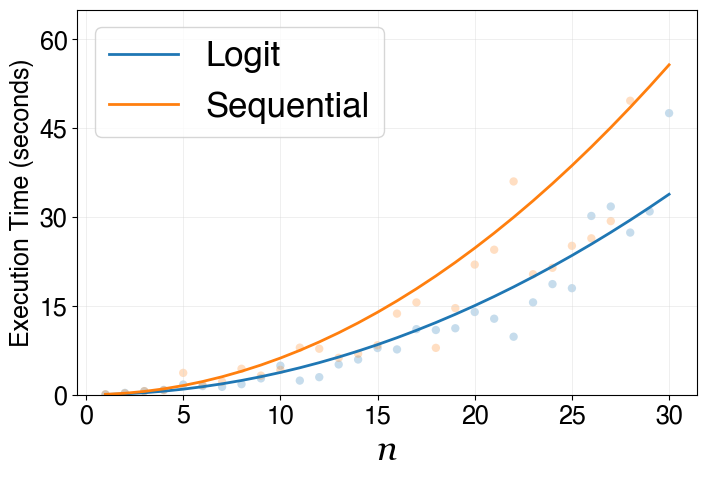

In [300]:
x, logit_eq = Logit_eq[:, 0], Logit_eq[:, 1]
schnell_eq = Schnell_eq[:, 1]


plt.figure(figsize=(8, 5))

plt.scatter(x, logit_eq, color='tab:blue', alpha=0.25, edgecolor='none')
plt.scatter(x, schnell_eq, color='tab:orange', alpha=0.25, edgecolor='none')

graph_time(2, x, logit_eq, color='tab:blue', linewidth=2, label="Logit")
graph_time(2, x, schnell_eq, color='tab:orange', linewidth=2, label="Sequential")

plt.ylim(0, 65)
plt.yticks(np.arange(0, 65, 15))
plt.xlabel("n", fontsize=25, fontdict={'family': 'georgia', 'style': 'italic'})
plt.ylabel("Execution Time (seconds)")
plt.title("")
plt.legend(fontsize=25)
plt.grid(color='lightgrey', linestyle='solid', linewidth=0.5, alpha=0.5)

plt.savefig(computation_folder + 'squared.pdf', format='pdf', bbox_inches='tight')
plt.show()

In [230]:
Logit_S_lambda = lambda J: SearchEq(I, F, G, t, λ, R, P, H.rvs(size=J), LogitSearch).S(np.linspace(0,1,J))
Logit_S = timing(200, Logit_S_lambda, H)

Schnell_S_lambda = lambda J: SearchEq(I, F, G, t, λ, R, P, H.rvs(size=J), SchnellSearch).S(np.linspace(0,1,J))
Schnell_S = timing(200, Schnell_S_lambda, H)

In [302]:
mpl.use('Agg')

In [289]:
%matplotlib inline

In [310]:
x, logit_s = Logit_S[:, 0], Logit_S[:, 1]
schnell_s = Schnell_S[:, 1]

plt.figure(figsize=(8, 5))

plt.scatter(x, logit_s, color='tab:blue', alpha=0.15, edgecolor='none')
plt.scatter(x, schnell_s, color='tab:orange', alpha=0.15, edgecolor='none')

graph_time(1, x, logit_s, color='tab:blue', linewidth=2, label="Logit")
graph_time(1, x, schnell_s, color='tab:orange', linewidth=2, label="Sequential")


plt.xlabel("n", fontsize=25, fontdict={'family': 'georgia', 'style': 'italic'})
plt.ylabel("Execution Time (seconds)")
plt.title("")
plt.legend(fontsize=25)
plt.grid(color='lightgrey', linestyle='solid', linewidth=0.5, alpha=0.5)
plt.show()

# Save and show
plt.savefig(computation_folder + 'linear.pdf', format='pdf', bbox_inches='tight')
plt.show()

/var/folders/d9/f39ks_q941961hvlpvd2zymc0000gn/T/ipykernel_12354/3127081499.py:18: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  plt.show()
/var/folders/d9/f39ks_q941961hvlpvd2zymc0000gn/T/ipykernel_12354/3127081499.py:22: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  plt.show()


In [237]:
Logit_eq_lambda_3 = lambda J: SearchEq(I, F, G, t, λ, R, P, H.rvs(size=J), LogitSearch).Eq_k(np.linspace(0,1,J),3)
Logit_eq_3 = timing(30, Logit_eq_lambda_3, H)

Two decimal convergence achieved in 2 iterations.
Two decimal convergence achieved in 2 iterations.
Two decimal convergence achieved in 2 iterations.
Two decimal convergence achieved in 3 iterations.
Two decimal convergence achieved in 2 iterations.
Two decimal convergence achieved in 2 iterations.
Two decimal convergence achieved in 2 iterations.
Two decimal convergence achieved in 2 iterations.
Two decimal convergence achieved in 3 iterations.
Two decimal convergence achieved in 2 iterations.
Two decimal convergence achieved in 4 iterations.
Two decimal convergence achieved in 3 iterations.
Two decimal convergence achieved in 3 iterations.
Two decimal convergence achieved in 3 iterations.
Two decimal convergence achieved in 4 iterations.
Two decimal convergence achieved in 3 iterations.
Two decimal convergence achieved in 3 iterations.
Two decimal convergence achieved in 3 iterations.
Two decimal convergence achieved in 3 iterations.
Two decimal convergence achieved in 3 iterations.


In [238]:
Logit_eq_lambda_4 = lambda J: SearchEq(I, F, G, t, λ, R, P, H.rvs(size=J), LogitSearch).Eq_k(np.linspace(0,1,J),4)
Logit_eq_4 = timing(30, Logit_eq_lambda_4, H)

Two decimal convergence achieved in 2 iterations.
Two decimal convergence achieved in 2 iterations.
Two decimal convergence achieved in 2 iterations.
Two decimal convergence achieved in 3 iterations.
Two decimal convergence achieved in 3 iterations.
Two decimal convergence achieved in 2 iterations.
Two decimal convergence achieved in 3 iterations.
Two decimal convergence achieved in 3 iterations.
Two decimal convergence achieved in 3 iterations.
Two decimal convergence achieved in 2 iterations.
Two decimal convergence achieved in 3 iterations.
Two decimal convergence achieved in 3 iterations.
Two decimal convergence achieved in 4 iterations.
Two decimal convergence achieved in 3 iterations.
Two decimal convergence achieved in 2 iterations.
Two decimal convergence achieved in 3 iterations.
Two decimal convergence achieved in 3 iterations.
Two decimal convergence achieved in 3 iterations.
Two decimal convergence achieved in 4 iterations.
Two decimal convergence achieved in 3 iterations.


In [241]:
Logit_eq_lambda_5 = lambda J: SearchEq(I, F, G, t, λ, R, P, H.rvs(size=J), LogitSearch).Eq_k(np.linspace(0,1,J),4)
Logit_eq_5 = timing(30, Logit_eq_lambda_5, H)

Two decimal convergence achieved in 2 iterations.
Two decimal convergence achieved in 2 iterations.
Two decimal convergence achieved in 3 iterations.
Two decimal convergence achieved in 2 iterations.
Two decimal convergence achieved in 2 iterations.
Two decimal convergence achieved in 3 iterations.
Two decimal convergence achieved in 2 iterations.
Two decimal convergence achieved in 3 iterations.
Two decimal convergence achieved in 3 iterations.
Two decimal convergence achieved in 2 iterations.
Two decimal convergence achieved in 2 iterations.
Two decimal convergence achieved in 4 iterations.
Two decimal convergence achieved in 3 iterations.
Two decimal convergence achieved in 2 iterations.
Two decimal convergence achieved in 3 iterations.
Two decimal convergence achieved in 3 iterations.
Two decimal convergence achieved in 3 iterations.
Two decimal convergence achieved in 3 iterations.
Two decimal convergence achieved in 3 iterations.
Two decimal convergence achieved in 3 iterations.


In [307]:
x, logit_eq = Logit_eq[:, 0], Logit_eq[:, 1]
logit_eq_3 = Logit_eq_3[:, 1]
logit_eq_4 = Logit_eq_4[:, 1]
logit_eq_5 = Logit_eq_5[:, 1]


plt.figure(figsize=(8, 5))

plt.scatter(x, logit_eq, color='tab:blue', alpha=0.25, edgecolor='none')
plt.scatter(x, logit_eq_3, color='tab:cyan', alpha=0.25, edgecolor='none')
plt.scatter(x, logit_eq_4, color='tab:purple', alpha=0.25, edgecolor='none')
plt.scatter(x, logit_eq_5, color='tab:olive', alpha=0.25, edgecolor='none')

graph_time(2, x, logit_eq, color='tab:blue', linewidth=2, label="2 decimals")
graph_time(2, x, logit_eq_3, color='tab:cyan', linewidth=2, label="3 decimals")
graph_time(2, x, logit_eq_4, color='tab:purple', linewidth=2, label="4 decimals")
graph_time(2, x, logit_eq_5, color='tab:olive', linewidth=2, label="5 decimals")

plt.ylim(0, 82)
plt.yticks(np.arange(0, 81, 20))
plt.xlabel("n", fontsize=25, fontdict={'family': 'georgia', 'style': 'italic'})
plt.ylabel("Execution Time (seconds)")
plt.title("")
plt.legend()
plt.grid(color='lightgrey', linestyle='solid', linewidth=0.5, alpha=0.5)

# Save and show
plt.savefig(computation_folder + 'decimals.pdf', format='pdf', bbox_inches='tight')
plt.show()

/var/folders/d9/f39ks_q941961hvlpvd2zymc0000gn/T/ipykernel_12354/2350470432.py:29: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  plt.show()


In [49]:
LogitModel = SearchEq(I, F, G, t, λ, R, P, V, LogitSearch)
SchnellModel = SearchEq(I, F, G, t, beta, R, P, V, SchnellSearch)

np.set_printoptions(suppress=True, precision=4)

<Token var=<ContextVar name='format_options' default={'edgeitems': 3, 'threshold': 1000, 'floatmode': 'maxprec', 'precision': 8, 'suppress': False, 'linewidth': 75, 'nanstr': 'nan', 'infstr': 'inf', 'sign': '-', 'formatter': None, 'legacy': 9223372036854775807, 'override_repr': None} at 0x1105d5260> at 0x12ae539c0>

In [50]:
SchnellModel.Eq_k(np.zeros(J), 2)

Two decimal convergence achieved in 5 iterations.


array([0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  ,
       0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  ,
       0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.1 ,
       0.11, 0.11, 0.12, 0.14, 0.27, 0.37, 0.54, 0.6 , 0.65, 0.67, 0.69,
       0.98, 0.98, 0.98, 0.98, 0.98, 0.98])

In [158]:
LogitModel.Eq_k(np.zeros(J), 4)

Two decimal convergence achieved in 4 iterations.


array([0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  ,
       0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  ,
       0.  , 0.  , 0.  , 0.  , 0.  , 0.05, 0.41, 0.41, 0.41, 0.49, 0.58,
       0.58, 0.61, 0.61, 0.64, 0.72, 0.74, 0.77, 0.77, 0.77, 0.8 , 0.81,
       0.92, 0.93, 0.95, 0.97, 0.97, 0.97])

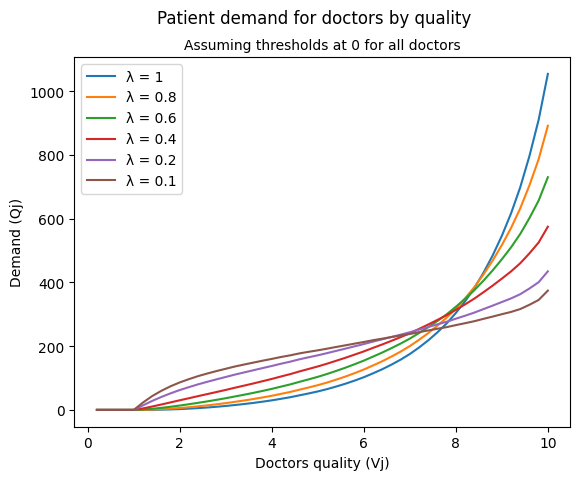

In [58]:
k0 = np.ones(J)
V_example = np.linspace(0.2,10,50)

lambda_values = [1, 0.8, 0.6, 0.4, 0.2, 0.1]

# Loop over lambda values and plot directly
x = V_example
for λ in lambda_values:
    y = SearchEq(I, F, G, t, λ, R, P, V_example, LogitSearch).Q(k0)
    plt.plot(x, y, label=f'λ = {λ}')

# Add legend and show plot
plt.legend()
plt.xlabel('Doctors quality (Vj)')
plt.ylabel('Demand (Qj)')
plt.suptitle('Patient demand for doctors by quality')
plt.title('Assuming thresholds at 0 for all doctors', fontsize=10)
plt.show()

In [61]:

SearchEq(I, F, G, t, λ, R, P, V_example, LogitSearch).X(k0)

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])

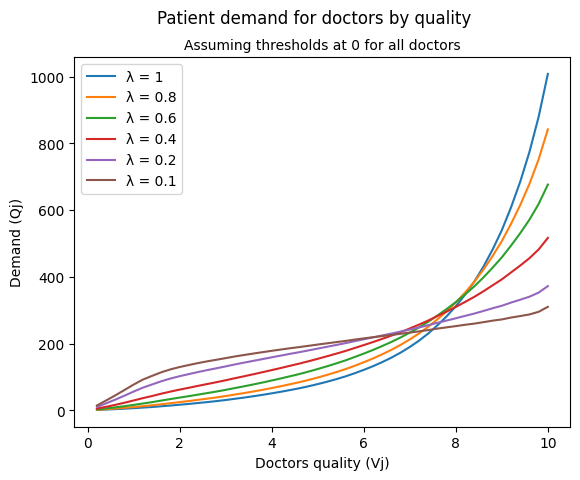

In [62]:
k0 = np.zeros(J)
V_example = np.linspace(0.2,10,50)

lambda_values = [1, 0.8, 0.6, 0.4, 0.2, 0.1]

# Loop over lambda values and plot directly
x = V_example
for λ in lambda_values:
    y = SearchEq(I, F, G, t, λ, R, P, V_example, LogitSearch).X(k0)
    plt.plot(x, y, label=f'λ = {λ}')

# Add legend and show plot
plt.legend()
plt.xlabel('Doctors quality (Vj)')
plt.ylabel('Demand (Qj)')
plt.suptitle('Patient demand for doctors by quality')
plt.title('Assuming thresholds at 0 for all doctors', fontsize=10)
plt.show()

Two decimal convergence achieved in 5 iterations.
Two decimal convergence achieved in 5 iterations.
Two decimal convergence achieved in 5 iterations.
Two decimal convergence achieved in 5 iterations.
Two decimal convergence achieved in 4 iterations.
Two decimal convergence achieved in 5 iterations.


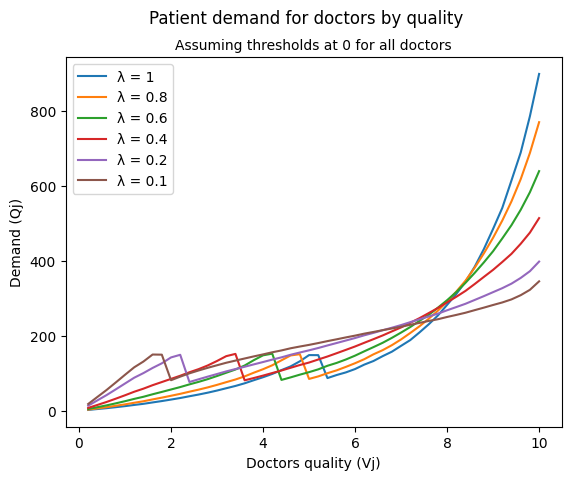

In [46]:
k0 = np.ones(J)
V_example = np.linspace(0.2,10,50)

lambda_values = [1, 0.8, 0.6, 0.4, 0.2, 0.1]

# Loop over lambda values and plot directly
x = V_example
for λ in lambda_values:
    k = SearchEq(I, F, G, t, λ, R, P, V_example, LogitSearch).Eq_k(k0, 2)
    y = SearchEq(I, F, G, t, λ, R, P, V_example, LogitSearch).Q(k)
    plt.plot(x, y, label=f'λ = {λ}')

# Add legend and show plot
plt.legend()
plt.xlabel('Doctors quality (Vj)')
plt.ylabel('Demand (Qj)')
plt.suptitle('Patient demand for doctors by quality')
plt.title('Taking the equilibrium vector of strategies', fontsize=10)
plt.show()

Two decimal convergence achieved in 5 iterations.
Two decimal convergence achieved in 5 iterations.


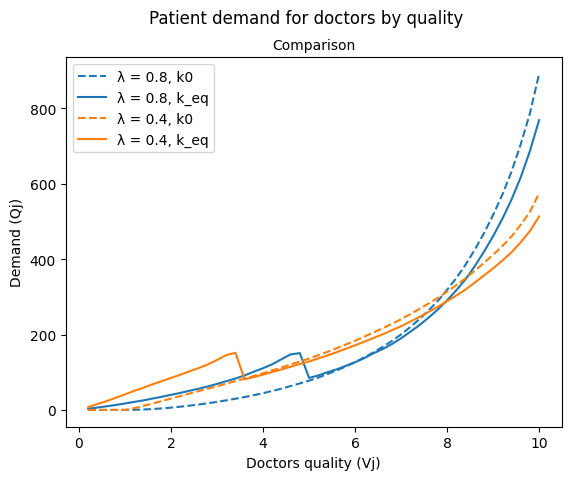

In [48]:
k0 = np.ones(J)
V_example = np.linspace(0.2,10,50)

lambda_values = [0.8, 0.4]
colors = ['tab:blue', 'tab:orange']

# Loop over lambda values and plot directly
x = V_example
for i, λ in enumerate(lambda_values):
    y_0 = SearchEq(I, F, G, t, λ, R, P, V_example, LogitSearch).Q(k0)
    k = SearchEq(I, F, G, t, λ, R, P, V_example, LogitSearch).Eq_k(k0, 2)
    y_eq = SearchEq(I, F, G, t, λ, R, P, V_example, LogitSearch).Q(k)
    plt.plot(x, y_0, label=f'λ = {λ}, k0', linestyle = 'dashed', color=colors[i])
    plt.plot(x, y_eq, label=f'λ = {λ}, k_eq', linestyle = 'solid', color=colors[i])

# Add legend and show plot
plt.legend()
plt.xlabel('Doctors quality (Vj)')
plt.ylabel('Demand (Qj)')
plt.suptitle('Patient demand for doctors by quality')
plt.title('Comparison', fontsize=10)
plt.show()

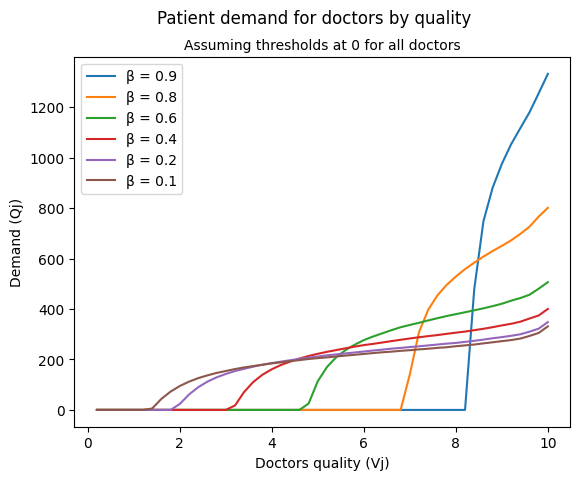

In [39]:
k0 = np.ones(J)
V_example = np.linspace(0.2,10,50)

beta_values = [0.9, 0.8, 0.6, 0.4, 0.2, 0.1]

# Loop over lambda values and plot directly
x = V_example
for beta in beta_values:
    y = SearchEq(I, F, G, t, beta, R, P, V_example, SchnellSearch).Q(k0)
    plt.plot(x, y, label=f'β = {beta}')

# Add legend and show plot
plt.legend()
plt.xlabel('Doctors quality (Vj)')
plt.ylabel('Demand (Qj)')
plt.suptitle('Patient demand for doctors by quality')
plt.title('Assuming thresholds at 0 for all doctors', fontsize=10)
plt.show()

Convergence not achieved, max iterations reached: 20
Two decimal convergence achieved in 5 iterations.
Two decimal convergence achieved in 4 iterations.
Two decimal convergence achieved in 4 iterations.
Two decimal convergence achieved in 4 iterations.
Two decimal convergence achieved in 4 iterations.


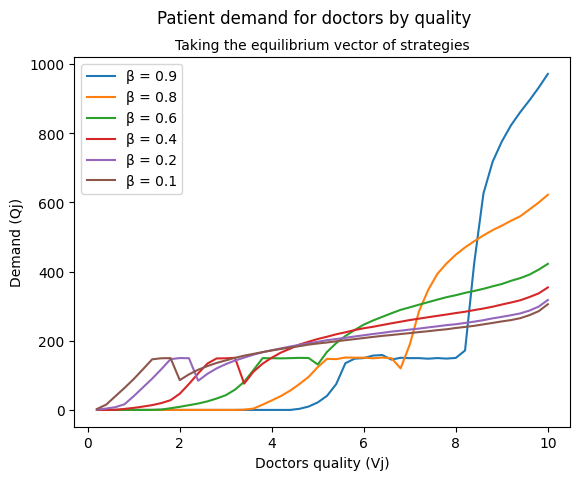

In [52]:
k0 = np.ones(J)
V_example = np.linspace(0.2,10,50)

beta_values = [0.9, 0.8, 0.6, 0.4, 0.2, 0.1]

# Loop over lambda values and plot directly
x = V_example
for beta in beta_values:
    k = SearchEq(I, F, G, t, beta, R, P, V_example, SchnellSearch).Eq_k(k0, 2)
    y = SearchEq(I, F, G, t, beta, R, P, V_example, SchnellSearch).Q(k)
    plt.plot(x, y, label=f'β = {beta}')

# Add legend and show plot
plt.legend()
plt.xlabel('Doctors quality (Vj)')
plt.ylabel('Demand (Qj)')
plt.suptitle('Patient demand for doctors by quality')
plt.title('Taking the equilibrium vector of strategies', fontsize=10)
plt.show()

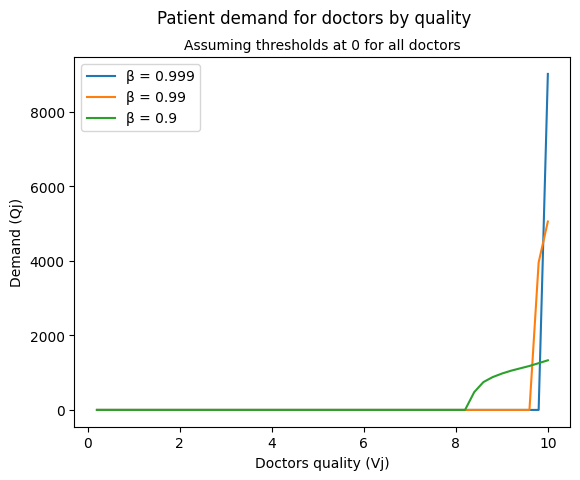

In [45]:
k0 = np.ones(J)
V_example = np.linspace(0.2,10,50)

beta_values = [0.999, 0.99, 0.9]

# Loop over lambda values and plot directly
x = V_example
for beta in beta_values:
    y = SearchEq(I, F, G, t, beta, R, P, V_example, SchnellSearch).Q(k0)
    plt.plot(x, y, label=f'β = {beta}')

# Add legend and show plot
plt.legend()
plt.xlabel('Doctors quality (Vj)')
plt.ylabel('Demand (Qj)')
plt.suptitle('Patient demand for doctors by quality')
plt.title('Assuming thresholds at 0 for all doctors', fontsize=10)
plt.show()

Two decimal convergence achieved in 5 iterations.
Two decimal convergence achieved in 4 iterations.


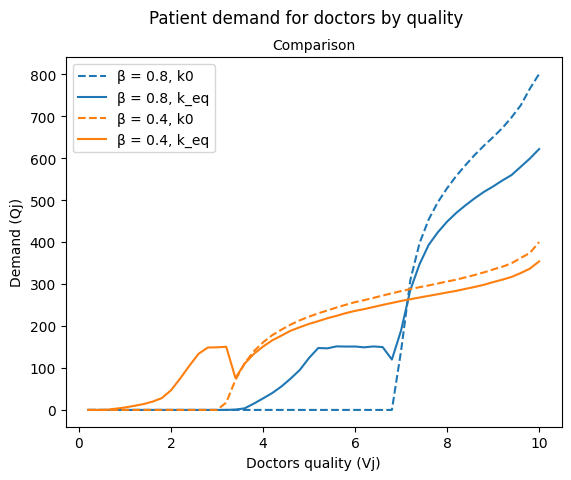

In [51]:
k0 = np.ones(J)
V_example = np.linspace(0.2,10,50)

beta_values = [0.8, 0.4]
colors = ['tab:blue', 'tab:orange']

# Loop over lambda values and plot directly
x = V_example
for i, beta in enumerate(beta_values):
    y_0 = SearchEq(I, F, G, t, beta, R, P, V_example, SchnellSearch).Q(k0)
    k = SearchEq(I, F, G, t, beta, R, P, V_example, SchnellSearch).Eq_k(k0, 2)
    y_eq = SearchEq(I, F, G, t, beta, R, P, V_example, SchnellSearch).Q(k)
    plt.plot(x, y_0, label=f'β = {beta}, k0', linestyle = 'dashed', color=colors[i])
    plt.plot(x, y_eq, label=f'β = {beta}, k_eq', linestyle = 'solid', color=colors[i])

# Add legend and show plot
plt.legend()
plt.xlabel('Doctors quality (Vj)')
plt.ylabel('Demand (Qj)')
plt.suptitle('Patient demand for doctors by quality')
plt.title('Comparison', fontsize=10)
plt.show()

Two decimal convergence achieved in 14 iterations.
Two decimal convergence achieved in 6 iterations.
Two decimal convergence achieved in 5 iterations.
Two decimal convergence achieved in 3 iterations.


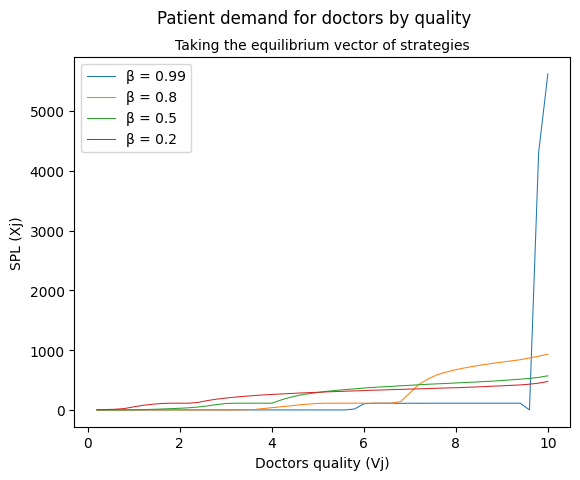

In [86]:
k0 = np.zeros(J)
V_example = np.linspace(0.2,10,50)

lambda_values = [0.99, 0.8, 0.5, 0.2]

k_results = []
# Loop over lambda values and plot directly
x = V_example
for λ in lambda_values:
    k = SearchEq(I, F, G, t, λ, R, P, V_example, SchnellSearch).Eq_k(k0, 2)
    y = SearchEq(I, F, G, t, λ, R, P, V_example, SchnellSearch).utility(k)
    k_results.append(k)
    plt.plot(x, y, label=f'β = {λ}', linewidth=0.75)

# Add legend and show plot
plt.legend()
plt.xlabel('Doctors quality (Vj)')
plt.ylabel('SPL (Xj)')
plt.suptitle('Patient demand for doctors by quality')
plt.title('Taking the equilibrium vector of strategies', fontsize=10)
plt.show()

In [94]:
k1 = np.array(k_results[0])
k2 = np.array(k_results[1])
k3 = np.array(k_results[2])
k4 = np.array(k_results[3])

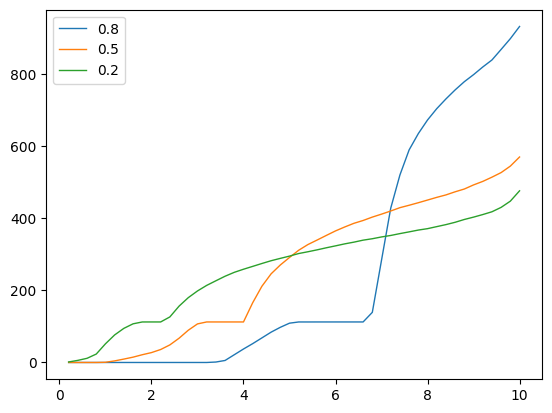

In [98]:
plt.plot(V_example, SearchEq(I, F, G, t, 0.8, R, P, V_example, SchnellSearch).utility(k2), label="0.8", linewidth=1)
plt.plot(V_example, SearchEq(I, F, G, t, 0.5, R, P, V_example, SchnellSearch).utility(k3), label="0.5", linewidth=1)
plt.plot(V_example, SearchEq(I, F, G, t, 0.2, R, P, V_example, SchnellSearch).utility(k4), label="0.2", linewidth=1)
plt.legend()

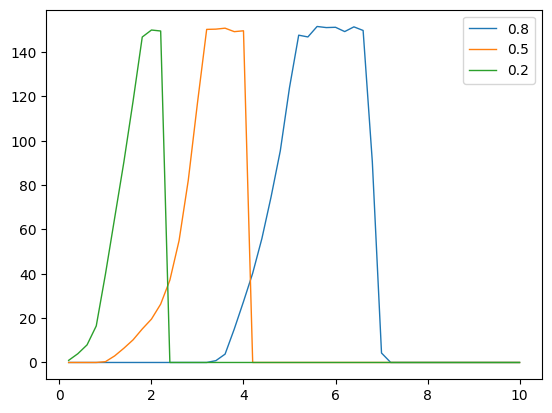

In [108]:
plt.plot(V_example, SearchEq(I, F, G, t, 0.8, R, P, V_example, SchnellSearch).X(k2), label="0.8", linewidth=1)
plt.plot(V_example, SearchEq(I, F, G, t, 0.5, R, P, V_example, SchnellSearch).X(k3), label="0.5", linewidth=1)
plt.plot(V_example, SearchEq(I, F, G, t, 0.2, R, P, V_example, SchnellSearch).X(k4), label="0.2", linewidth=1)
plt.legend()

In [111]:
k1

array([0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  ,
       0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  ,
       0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.06, 0.09, 0.11,
       0.13, 0.15, 0.18, 0.2 , 0.24, 0.28, 0.34, 0.4 , 0.48, 0.57, 0.69,
       0.8 , 0.9 , 0.93, 1.  , 0.98, 0.99])

In [99]:
SearchEq(I, F, G, t, 0.2, R, P, V_example, SchnellSearch).utility(k4)

array([  1.42749401,   5.85493433,  11.5803469 ,  23.35139836,
        51.83435284,  76.49271172,  94.72524329, 107.31472177,
       112.44768786, 112.49996479, 112.4986384 , 126.46557239,
       156.40476282, 179.94266447, 198.52701083, 213.98400067,
       226.79425091, 239.43860159, 250.25996777, 258.850911  ,
       266.76501224, 274.76429535, 282.46396922, 288.97120464,
       295.27043489, 302.45056252, 307.36483315, 312.66748118,
       318.38283014, 323.73435415, 329.26487543, 334.0468194 ,
       339.57162643, 343.51930532, 348.4936343 , 352.59395806,
       357.7785051 , 362.57861455, 367.58766993, 371.49590651,
       377.13183155, 382.73128479, 389.20344866, 396.99939646,
       403.50118218, 410.62370965, 418.37004664, 430.64793126,
       447.87065853, 476.5373252 ])

In [67]:
k_main = np.array(k_results[1])
SearchEq(I, F, G, t, 0.8, R, P, V_example, LogitSearch).utility(k_main)

array([   4.58199324,    9.30575561,   13.90461893,   18.95192344,
         24.11319464,   29.69938386,   34.76314299,   40.77619691,
         46.30421421,   51.95709945,   57.45516816,   63.31611246,
         68.6078385 ,   74.05291341,   79.6934571 ,   85.26007263,
         90.25471035,   95.4341194 ,  100.72724632,  104.78144691,
        108.34820363,  111.28648794,  112.46699511,  112.49748875,
        114.87885633,  125.38513615,  137.13874387,  149.39625954,
        163.08005866,  177.43006644,  193.73640931,  210.79508702,
        229.52239664,  249.88486379,  272.30139076,  297.31134274,
        324.69308632,  354.77730784,  387.05563235,  424.25973549,
        464.77353363,  509.56758597,  560.92316779,  617.35363676,
        679.51259487,  748.86009401,  827.09111631,  917.15977339,
       1018.68392194, 1144.21620277])

In [58]:
SearchEq(I, F, G, t, 0.8, R, P, V_example, LogitSearch).utility(np.array(k_results))

array([   4.58199324,    9.30575561,   13.90461893,   18.95192344,
         24.11319464,   29.69938386,   34.76314299,   40.77619691,
         46.30421421,   51.95709945,   57.45516816,   63.31611246,
         68.6078385 ,   74.05291341,   79.6934571 ,   85.26007263,
         90.25471035,   95.4341194 ,  100.72724632,  104.78144691,
        108.34820363,  111.28648794,  112.46699511,  112.49748875,
        114.87885633,  125.38513615,  137.13874387,  149.39625954,
        163.08005866,  177.43006644,  193.73640931,  210.79508702,
        229.52239664,  249.88486379,  272.30139076,  297.31134274,
        324.69308632,  354.77730784,  387.05563235,  424.25973549,
        464.77353363,  509.56758597,  560.92316779,  617.35363676,
        679.51259487,  748.86009401,  827.09111631,  917.15977339,
       1018.68392194, 1144.21620277])

In [83]:
def graph_component_i(f, k_original, i_values, start, stop, num_points=50):
    """
    Function to graph the effect of changing specific components of a vector on the output of a function.

    Parameters:
    - f: The function to evaluate.
    - k_original: The original input vector.
    - i_values: A list of indices of the components to change (e.g., [1, 10, 20, 30, 40]).
    - start: The start value for the components.
    - stop: The stop value for the components.
    - num_points: The number of points in the linspace (default is 100).

    Returns:
    - A plot of f(k) as the selected components of k change.
    """
    # Check if k_original has enough elements for the highest index in i_values
    if len(k_original) < max(i_values) + 1:
        raise ValueError("Input vector must be large enough to accommodate all indices in i_values.")

    # Generate a linspace for the components
    linspace_values = np.linspace(start, stop, num_points)
    
    # Keep the original vector unchanged for components not in i_values
    k_fixed = np.copy(k_original)
    
    # Plot results for each index in i_values
    for i in i_values:
        # Store the results of the function evaluations for this component
        results = []
        
        # Evaluate the function over the linspace
        for value in linspace_values:
            k_fixed[i] = value  # Update the i-th component
            result = f(k_fixed)[i]  # Evaluate the function (assumes f returns a vector)
            results.append(result)
        
        # Plot the results for this component
        plt.plot(linspace_values, results, label=f'Doctor {i+1}')
    
    # Customize the plot
    plt.title("Function evaluation over varying components")
    plt.xlabel("Component value")
    plt.ylabel("f(k)")
    plt.grid(True)
    plt.legend()
    plt.show()


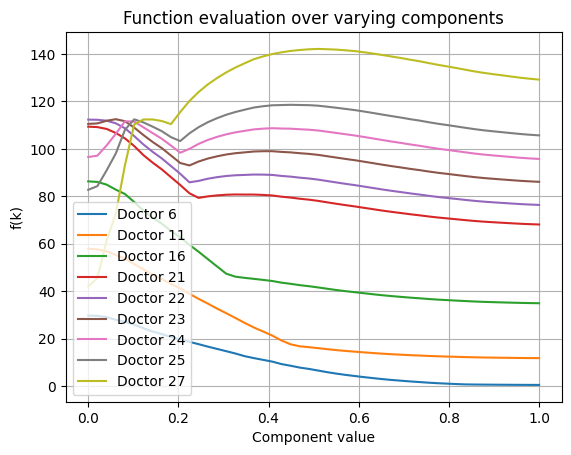

In [113]:
funktion = lambda x: SearchEq(I, F, G, t, 0.8, R, P, V_example, LogitSearch).utility(x)
graph_component_i(funktion, k_main, [5,10,15,20,21,22,23,24,26], 0, 1, num_points=50)

In [102]:
k2[24]

np.float64(0.0)

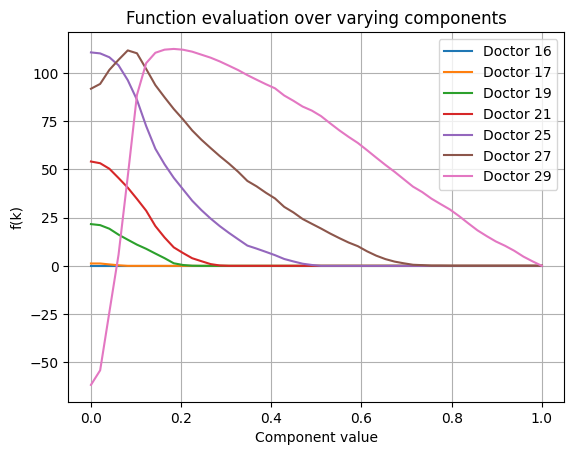

In [105]:
funktion = lambda x: SearchEq(I, F, G, t, 0.8, R, P, V_example, SchnellSearch).utility(x)
graph_component_i(funktion, k2, [15,16,18,20,24,26,28], 0, 1, num_points=50)

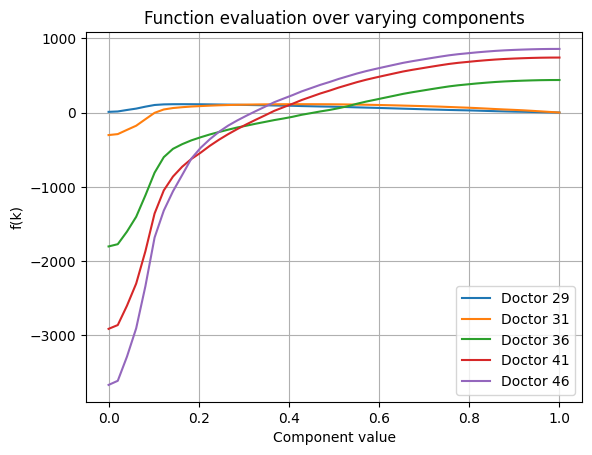

In [107]:
graph_component_i(funktion, k2, [28,30,35,40,45], 0, 1, num_points=50)

In [77]:
k_main[23]

np.float64(0.07)

In [26]:
k_wanted = np.array(k_results[0])
k_wanted[20] += 0.1

In [25]:
SearchEq(I, F, G, t, λ, R, P, V_example, LogitSearch).utility(k_wanted)

array([ 16.42265567,  32.17414137,  46.81747172,  60.87506406,
        73.49924983,  83.89383247,  91.09050369,  97.40451591,
       101.87466019, 105.20792136, 107.68610019, 109.68660479,
       111.02787491, 111.94211565, 112.43494569, 112.43919068,
       111.99743731, 111.02975228, 109.34679019, 107.28755377,
       109.98437501, 100.96906954,  97.23266098,  91.14237938,
        82.16376528,  84.64409544, 174.08904172, 186.57855721,
       203.68760279, 216.36042449, 228.35384312, 243.30328499,
       258.3759657 , 275.18974506, 288.02469763, 304.94525678,
       317.03309155, 330.77431794, 343.3113287 , 356.54131077,
       370.54247324, 384.12942354, 397.24651795, 411.79390698,
       425.38362378, 439.6970607 , 455.60012732, 473.85263561,
       493.8938272 , 526.81643501])

In [30]:
start = 0
stop = 1
logit = lambda x: SearchEq(I, F, G, t, λ, R, P, V_example, LogitSearch).utility(x)

k_resp = best_response(k_wanted, logit, start, stop)

In [36]:
SearchEq(I, F, G, t, λ, R, P, V_example, LogitSearch).utility(y)

array([ 19.47007974,  37.70730996,  53.96706447,  69.33137399,
        82.54625373,  93.3225212 , 100.17896083, 106.06060287,
       109.71923976, 112.19012109, 112.49618545, 114.09264296,
       124.9777442 , 135.62676063, 145.88068648, 156.25303205,
       165.6897507 , 175.02613754, 184.532701  , 193.78344701,
       203.57393491, 212.57742771, 222.88347193, 231.77482875,
       240.42691882, 249.88022489, 259.92387197, 269.63510832,
       279.77902567, 289.67074186, 300.46537356, 310.45177486,
       320.885791  , 330.9048746 , 341.40410041, 352.96343555,
       364.31246206, 376.04587126, 387.11383978, 400.5645581 ,
       413.31070814, 426.79699157, 442.04238716, 457.29366898,
       473.13320936, 488.93074864, 506.95900176, 529.64783557,
       557.02858231, 595.42044523])

In [28]:
k_wanted

array([0.     , 0.     , 0.     , 0.     , 0.     , 0.     , 0.     ,
       0.     , 0.     , 0.     , 0.     , 0.     , 0.     , 0.     ,
       0.     , 0.     , 0.     , 0.     , 0.     , 0.     , 0.     ,
       0.     , 0.     , 0.     , 0.     , 0.06218, 0.37224, 0.40561,
       0.45448, 0.48886, 0.51388, 0.55374, 0.59397, 0.64279, 0.67272,
       0.72179, 0.73986, 0.77069, 0.79956, 0.81896, 0.85088, 0.88116,
       0.88689, 0.90984, 0.92097, 0.93767, 0.94797, 0.95651, 0.96737,
       0.96866])

In [37]:
x = np.zeros(J) + 1
y = np.zeros(J)

start = 0
stop = 1
custom_function = lambda x: SearchEq(I, F, G, t, λ, R, P, V_example, LogitSearch).utility(x)

lambda_best = lambda x: best_response(x, custom_function, start, stop)

n = 0
while not np.array_equal(x, y):
    n += 1
    x = y
    if n > 2:
        print(f"Convergence not achieved, max iterations reached")
        break
    y = lambda_best(x)

y

Convergence not achieved, max iterations reached


array([0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  ,
       0.88, 0.88, 0.88, 0.88, 0.88, 0.89, 0.9 , 0.9 , 0.9 , 0.91, 0.91,
       0.91, 0.91, 0.91, 0.92, 0.92, 0.92, 0.93, 0.93, 0.93, 0.94, 0.94,
       0.94, 0.94, 0.94, 0.94, 0.95, 0.95, 0.95, 0.95, 0.96, 0.96, 0.96,
       0.96, 0.96, 0.96, 0.96, 0.97, 0.97])

In [53]:
mate = SearchEq(I, F, G, t, 0.6, R, P, V_example, LogitSearch).Eq_k(np.zeros(J), 2)
mate

Two decimal convergence achieved in 4 iterations.


array([0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  ,
       0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.06, 0.55,
       0.58, 0.59, 0.62, 0.65, 0.65, 0.7 , 0.73, 0.74, 0.75, 0.77, 0.8 ,
       0.81, 0.82, 0.84, 0.85, 0.88, 0.88, 0.9 , 0.91, 0.91, 0.92, 0.93,
       0.94, 0.94, 0.95, 0.96, 0.96, 0.97])

In [54]:
SearchEq(I, F, G, t, 0.6, R, P, V_example, LogitSearch).utility(mate)

array([  6.84089135,  13.77092353,  20.51418967,  27.71854985,
        34.94707731,  42.42597908,  48.93767104,  56.26516721,
        62.70549964,  68.93873355,  74.76952747,  80.73065667,
        85.84737621,  90.95223709,  96.03804054, 100.63494138,
       104.46395767, 108.16488504, 111.3575421 , 112.47398399,
       112.47645111, 115.50139255, 125.96574143, 135.96353683,
       146.39306859, 158.0206344 , 170.70919709, 183.84100687,
       198.16116238, 213.02751118, 229.5075945 , 246.3529734 ,
       264.50145097, 283.58671158, 304.16371653, 326.83099304,
       351.02751257, 377.04634497, 404.34904175, 435.43750633,
       468.0757223 , 503.33583409, 542.88565618, 585.3725059 ,
       630.83801755, 680.16843941, 734.76310506, 797.47460283,
       866.09726519, 952.3600115 ])

In [44]:
SearchEq(I, F, G, t, 0.6, R, P, V_example, LogitSearch).X(mate)

array([  3.08641536,   6.33772632,   9.57537177,  13.21690414,
        17.04376257,  21.31385767,  25.31090103,  30.23038524,
        34.9384636 ,  39.96100641,  45.07637841,  50.81947011,
        56.30671155,  62.31067729,  68.99809521,  76.18953005,
        83.29874116,  91.57760601, 101.47628688, 110.70991705,
       121.18404479, 134.42109078, 147.4307632 , 150.70869545,
        49.82292646,  48.87610518,  50.93133542,  49.2498991 ,
        49.61846978,  50.19670567,  49.82949713,  54.37214528,
        50.42636322,  49.56662785,  50.71837885,  52.21941167,
        50.8376723 ,  50.9422132 ,  50.92910936,  49.19276746,
        47.97242276,  45.42083442,  46.78123462,  48.93483644,
        49.23623926,  48.05858981,  45.19561768,  41.53222798,
        48.57810316,  43.27680947])

In [49]:
mate_copy = mate
mate_copy[28] = 0
SearchEq(I, F, G, t, 0.8, R, P, V_example, LogitSearch).utility(mate_copy)

array([   4.47512294,    9.09346958,   13.60400106,   18.5532158 ,
         23.62514679,   29.10837058,   34.107116  ,   40.0361309 ,
         45.49411601,   51.06684528,   56.48046742,   62.2440239 ,
         67.47817065,   72.84337209,   78.40082877,   83.92314145,
         88.89564969,   94.02069442,   99.21311774,  103.35094667,
        107.03582538,  110.18418235,  111.95296701,  112.11416569,
        114.30276598,  124.75920115,  136.45909265,  148.66195533,
         45.680845  ,  176.51057873,  192.66243247,  209.58278558,
        228.15127221,  248.37239503,  270.63546713,  295.45636999,
        322.65603864,  352.54709555,  384.64006839,  421.56780919,
        461.83945342,  506.40453896,  557.37763814,  613.38351915,
        675.18633587,  743.97214556,  821.66045364,  910.53758887,
       1011.13805072, 1134.81057379])

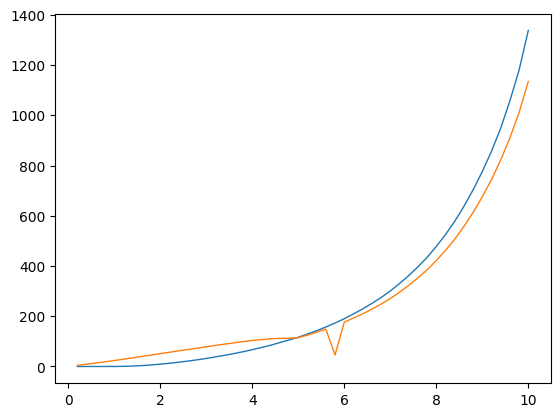

In [52]:
plt.plot(V_example, SearchEq(I, F, G, t, 0.8, R, P, V_example, LogitSearch).utility(np.ones(J)), label="ideal", linewidth=1)
plt.plot(V_example, SearchEq(I, F, G, t, 0.8, R, P, V_example, LogitSearch).utility(mate), label="ideal", linewidth=1)